## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/usr/local/google/home/carverforbes/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_50_50'
notebook = 'training_rms_dnn'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']
redo = False

In [ ]:
# Import the dataset as a pandas Dataframe object.
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, redo)

In [6]:
df.head()

,label,rms
0,1,"[[0.02405279, 0.023330143, 0.023758966, 0.0242..."
1,1,"[[0.018282387, 0.018027905, 0.017703341, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04338157, 0.04964902, 0.05274851, 0.055846..."
4,0,"[[0.006664924, 0.0066831713, 0.0066637434, 0.0..."


In [7]:
def fix_dataframe(dataframe):
    # temp bug fix for rows with None features
    # and rows with different number of elements per frame
    bad_rows = []
    for i in dataframe.index:
        if dataframe.rms[i] is None:
            bad_rows.append(i)
        elif dataframe.rms[i][0] is None:
            bad_rows.append(i)
        elif len(dataframe.rms[i][0]) != 431:
            bad_rows.append(i)
    new_dataframe = dataframe.drop(bad_rows)
    return new_dataframe

In [8]:
def shuffle_dataframe(dataframe):
    # Shuffle the dataset/dataframe.
    dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
    return dataframe

In [9]:
def dataframe_to_x_y(dataframe):
    X = np.array(dataframe.rms.tolist(), dtype=object)
    y = np.array(dataframe.label.tolist())
    
    # Convert arrays of objects to arrays of floats.
    X = tf.keras.backend.cast_to_floatx(X)
    y = tf.keras.backend.cast_to_floatx(y)
    return X, y

In [10]:
def data_preprocessing(dataframe):
    print('Dropping incongruent features from dataframe')
    dataframe = fix_dataframe(dataframe)
    print('shuffling dataframe')
    dataframe = shuffle_dataframe(dataframe)
    print('Getting X, y out of dataframe')
    X, y = dataframe_to_x_y(dataframe)
    x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)
    return x_train, y_train, x_val, y_val

In [11]:
x_train, y_train, x_val, y_val = data_preprocessing(df)

Dropping incongruent features from dataframe
shuffling dataframe
Getting X, y out of dataframe


In [23]:
x_train = x_train.reshape(x_train.shape[0], 431)
x_val = x_val.reshape(x_val.shape[0], 431)

In [24]:
def make_dir(path):
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            return False
    return True

In [25]:
# Define the plotting function.
def plot_curve(epochs, hist, dest_path, notebook_filename, dataset_filename, list_of_metrics, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    make_dir(dest_path)    
    path = os.path.join(dest_path, notebook_filename)
    make_dir(path)
    path = os.path.join(path, dataset_filename)
    make_dir(path)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    filename = '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Training 1

In [26]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Output (Dense)               (None, 1)                 432       
Total params: 372,816
Trainable params: 372,816
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
351/351 [==============================] - 5s 15ms/step - loss: 1.7966 - accuracy: 0.5349 - precision: 0.3684 - recall: 0.0034 - val_loss: 0.7039 - val_accuracy: 0.5349 - val_precision: 1.0000 - val_recall: 9.8039e-04
Epoch 2/100
351/351 [==============================] - 5s 13ms/step - loss: 0.6982 - accuracy: 0.5387 - precision: 0.6667 - recall: 0.0113 - val_los

Epoch 34/100
351/351 [==============================] - 5s 13ms/step - loss: 0.6559 - accuracy: 0.5870 - precision: 0.7563 - recall: 0.1619 - val_loss: 0.6852 - val_accuracy: 0.5586 - val_precision: 0.6480 - val_recall: 0.1137
Epoch 35/100
351/351 [==============================] - 5s 13ms/step - loss: 0.6564 - accuracy: 0.5842 - precision: 0.7512 - recall: 0.1552 - val_loss: 0.6928 - val_accuracy: 0.5559 - val_precision: 0.6621 - val_recall: 0.0941
Epoch 36/100
351/351 [==============================] - 4s 13ms/step - loss: 0.6552 - accuracy: 0.5833 - precision: 0.7562 - recall: 0.1503 - val_loss: 0.6969 - val_accuracy: 0.5650 - val_precision: 0.6754 - val_recall: 0.1265
Epoch 37/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6570 - accuracy: 0.5839 - precision: 0.7539 - recall: 0.1530 - val_loss: 0.6830 - val_accuracy: 0.5605 - val_precision: 0.7209 - val_recall: 0.0912
Epoch 38/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6550 - accura

351/351 [==============================] - 4s 11ms/step - loss: 0.6416 - accuracy: 0.5997 - precision: 0.7672 - recall: 0.1970 - val_loss: 0.7247 - val_accuracy: 0.5710 - val_precision: 0.6361 - val_recall: 0.1833
Epoch 71/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6409 - accuracy: 0.6020 - precision: 0.7737 - recall: 0.2010 - val_loss: 0.6985 - val_accuracy: 0.5614 - val_precision: 0.6497 - val_recall: 0.1255
Epoch 72/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6379 - accuracy: 0.6068 - precision: 0.7834 - recall: 0.2108 - val_loss: 0.7197 - val_accuracy: 0.5778 - val_precision: 0.6338 - val_recall: 0.2206
Epoch 73/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6407 - accuracy: 0.6019 - precision: 0.7694 - recall: 0.2027 - val_loss: 0.6960 - val_accuracy: 0.5623 - val_precision: 0.6631 - val_recall: 0.1216
Epoch 74/100
351/351 [==============================] - 4s 12ms/step - loss: 0.6377 - accuracy: 0.6094 - 

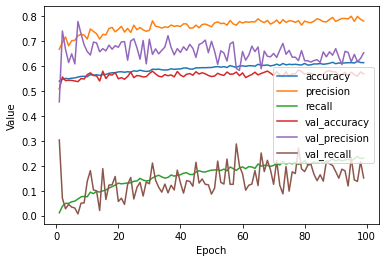

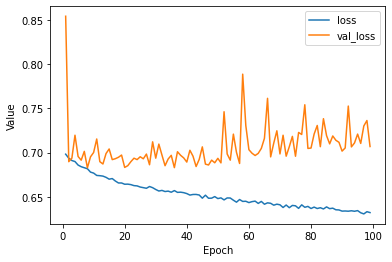

In [27]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 2

In [28]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=40, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden2 (Dense)              (None, 40)                17280     
_________________________________________________________________
Output (Dense)               (None, 1)                 41        
Total params: 389,705
Trainable params: 389,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
351/351 [==============================] - 5s 15ms/step - loss: 2.0659 - accuracy: 0.5360 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6943 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoc

Epoch 33/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6623 - accuracy: 0.5604 - precision: 0.7320 - recall: 0.0827 - val_loss: 0.6963 - val_accuracy: 0.5623 - val_precision: 0.6723 - val_recall: 0.1167
Epoch 34/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6600 - accuracy: 0.5644 - precision: 0.7431 - recall: 0.0932 - val_loss: 0.7004 - val_accuracy: 0.5678 - val_precision: 0.6667 - val_recall: 0.1431
Epoch 35/250
351/351 [==============================] - 5s 14ms/step - loss: 0.6597 - accuracy: 0.5620 - precision: 0.7162 - recall: 0.0925 - val_loss: 0.6962 - val_accuracy: 0.5427 - val_precision: 0.6216 - val_recall: 0.0451
Epoch 36/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6601 - accuracy: 0.5646 - precision: 0.7341 - recall: 0.0964 - val_loss: 0.6950 - val_accuracy: 0.5586 - val_precision: 0.6710 - val_recall: 0.1020
Epoch 37/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6602 - accura

351/351 [==============================] - 5s 14ms/step - loss: 0.6547 - accuracy: 0.5648 - precision: 0.7432 - recall: 0.0947 - val_loss: 0.6980 - val_accuracy: 0.5655 - val_precision: 0.6977 - val_recall: 0.1176
Epoch 70/250
351/351 [==============================] - 5s 14ms/step - loss: 0.6537 - accuracy: 0.5652 - precision: 0.7136 - recall: 0.1048 - val_loss: 0.6912 - val_accuracy: 0.5559 - val_precision: 0.7238 - val_recall: 0.0745
Epoch 71/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6517 - accuracy: 0.5687 - precision: 0.7399 - recall: 0.1085 - val_loss: 0.6983 - val_accuracy: 0.5550 - val_precision: 0.7064 - val_recall: 0.0755
Epoch 72/250
351/351 [==============================] - 5s 14ms/step - loss: 0.6551 - accuracy: 0.5667 - precision: 0.7463 - recall: 0.0999 - val_loss: 0.6823 - val_accuracy: 0.5536 - val_precision: 0.7386 - val_recall: 0.0637
Epoch 73/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6502 - accuracy: 0.5692 - 

351/351 [==============================] - 5s 14ms/step - loss: 0.6411 - accuracy: 0.5687 - precision: 0.7227 - recall: 0.1141 - val_loss: 0.6906 - val_accuracy: 0.5450 - val_precision: 0.7949 - val_recall: 0.0304
Epoch 106/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6390 - accuracy: 0.5703 - precision: 0.7322 - recall: 0.1164 - val_loss: 0.6973 - val_accuracy: 0.5874 - val_precision: 0.6859 - val_recall: 0.2098
Epoch 107/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6408 - accuracy: 0.5732 - precision: 0.7400 - recall: 0.1232 - val_loss: 0.6856 - val_accuracy: 0.5623 - val_precision: 0.6784 - val_recall: 0.1137
Epoch 108/250
351/351 [==============================] - 5s 14ms/step - loss: 0.6401 - accuracy: 0.5728 - precision: 0.7454 - recall: 0.1203 - val_loss: 0.6973 - val_accuracy: 0.5596 - val_precision: 0.6978 - val_recall: 0.0951
Epoch 109/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6385 - accuracy: 0.572

Epoch 141/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6283 - accuracy: 0.5665 - precision: 0.7363 - recall: 0.1023 - val_loss: 0.6956 - val_accuracy: 0.5591 - val_precision: 0.6667 - val_recall: 0.1059
Epoch 142/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6306 - accuracy: 0.5734 - precision: 0.7274 - recall: 0.1287 - val_loss: 0.6906 - val_accuracy: 0.5596 - val_precision: 0.6752 - val_recall: 0.1039
Epoch 143/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6286 - accuracy: 0.5726 - precision: 0.7353 - recall: 0.1230 - val_loss: 0.7022 - val_accuracy: 0.5774 - val_precision: 0.6655 - val_recall: 0.1853
Epoch 144/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6292 - accuracy: 0.5750 - precision: 0.7339 - recall: 0.1316 - val_loss: 0.6915 - val_accuracy: 0.5641 - val_precision: 0.6879 - val_recall: 0.1167
Epoch 145/250
351/351 [==============================] - 6s 18ms/step - loss: 0.6302 - a

Epoch 177/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6247 - accuracy: 0.5729 - precision: 0.7365 - recall: 0.1237 - val_loss: 0.6982 - val_accuracy: 0.5513 - val_precision: 0.7467 - val_recall: 0.0549
Epoch 178/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6268 - accuracy: 0.5742 - precision: 0.7577 - recall: 0.1208 - val_loss: 0.6931 - val_accuracy: 0.5559 - val_precision: 0.6621 - val_recall: 0.0941
Epoch 179/250
351/351 [==============================] - 4s 12ms/step - loss: 0.6246 - accuracy: 0.5725 - precision: 0.7435 - recall: 0.1198 - val_loss: 0.6997 - val_accuracy: 0.5687 - val_precision: 0.6777 - val_recall: 0.1402
Epoch 180/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6230 - accuracy: 0.5732 - precision: 0.7352 - recall: 0.1250 - val_loss: 0.6915 - val_accuracy: 0.5682 - val_precision: 0.6682 - val_recall: 0.1441
Epoch 181/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6234 - a

Epoch 213/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6210 - accuracy: 0.5695 - precision: 0.7285 - recall: 0.1149 - val_loss: 0.7009 - val_accuracy: 0.5673 - val_precision: 0.6500 - val_recall: 0.1529
Epoch 214/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6211 - accuracy: 0.5734 - precision: 0.7366 - recall: 0.1252 - val_loss: 0.6944 - val_accuracy: 0.5600 - val_precision: 0.6750 - val_recall: 0.1059
Epoch 215/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6193 - accuracy: 0.5790 - precision: 0.7356 - recall: 0.1444 - val_loss: 0.6964 - val_accuracy: 0.5632 - val_precision: 0.6760 - val_recall: 0.1186
Epoch 216/250
351/351 [==============================] - 4s 13ms/step - loss: 0.6204 - accuracy: 0.5704 - precision: 0.7378 - recall: 0.1149 - val_loss: 0.6952 - val_accuracy: 0.5586 - val_precision: 0.6626 - val_recall: 0.1059
Epoch 217/250
351/351 [==============================] - 4s 12ms/step - loss: 0.6215 - a

Epoch 249/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6184 - accuracy: 0.5703 - precision: 0.7083 - recall: 0.1255 - val_loss: 0.7028 - val_accuracy: 0.5568 - val_precision: 0.6788 - val_recall: 0.0912
Epoch 250/250
351/351 [==============================] - 5s 13ms/step - loss: 0.6193 - accuracy: 0.5711 - precision: 0.7402 - recall: 0.1164 - val_loss: 0.6958 - val_accuracy: 0.5472 - val_precision: 0.7059 - val_recall: 0.0471
Training Performance
---------------------------------
loss:  0.6125455498695374
accuracy:  0.5539830923080444
precision:  0.8178137540817261
recall:  0.04969249665737152

Validation Performance
---------------------------------
loss:  0.6957617402076721
accuracy:  0.5472387075424194
precision:  0.7058823704719543
recall:  0.0470588244497776


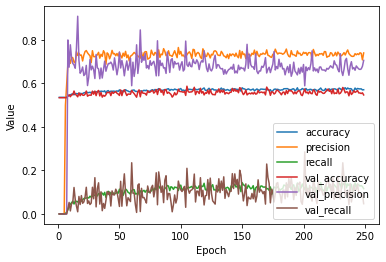

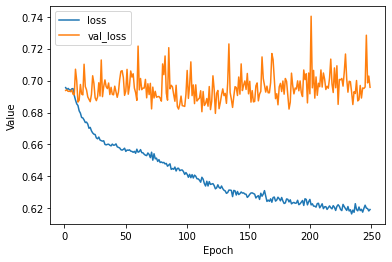

In [29]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 250
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 3

In [30]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden2'))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden3'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden2 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden3 (Dense)              (None, 20)                8640      
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 567,237
Trainable params: 567,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
351/351 [==============================] - 6s 18ms/step - loss: 1.7070 - accuracy: 0.5361 - precision:

351/351 [==============================] - 6s 16ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 31/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 32/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/200
351/351 [==============================] - 5s 15ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/200
351/351 [===================

Epoch 64/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 65/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 66/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 67/200
351/351 [==============================] - 6s 16ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/200
351/351 [======

Epoch 98/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 99/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 100/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 101/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 102/200
351/351 [===

351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 132/200
351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 133/200
351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 134/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 135/200
351/351 [===============

Epoch 165/200
351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 166/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7098 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 167/200
351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 168/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 169/200
351/351 [=

351/351 [==============================] - 6s 17ms/step - loss: 0.7095 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7099 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 199/200
351/351 [==============================] - 6s 17ms/step - loss: 0.7097 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 200/200
351/351 [==============================] - 6s 18ms/step - loss: 0.7096 - accuracy: 0.5361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Training Performance
---------------------------------
loss:  0.7095180153846741
accuracy:  0.5360648036003113
precision:  0.0
recall:  0.0

Validation Performance
---------------------------------
loss:  0.7097398042678833
accuracy:  0.5344591736793518
precision:  0.0
recall:  0.0

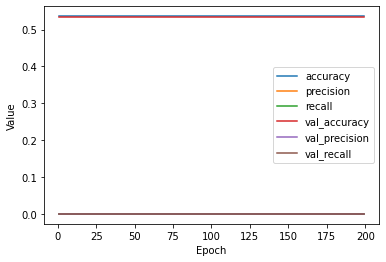

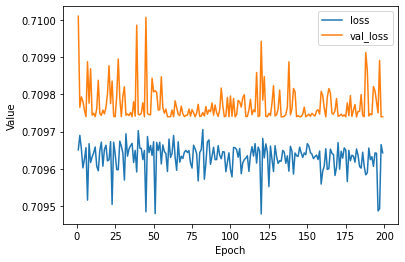

In [31]:
# The following variables are the hyperparameters.
learning_rate = 0.002
epochs = 200
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

# Print the models structure
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])